In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers, mixed_precision as mp
import os
from skimage import io
from sklearn.model_selection import train_test_split
import tensorflow as tf
import visualkeras

SEED = 42
TEST_PROP = 0.2
IMAGE_SHAPE = (227, 227)
BASE_PATH = "hirise-map-proj-v3_2/"
IMAGES_PATH = BASE_PATH + "map-proj-v3_2/"

mp.set_global_policy('mixed_float16')

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [4]:
devices = tf.config.list_physical_devices('GPU')
if len(devices) == 0: print("Please install the latest TensorFlow GPU release.")

[]

In [2]:
!nvidia-smi

'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


## Dataset creation

In [3]:
class_map = pd.read_csv(BASE_PATH + "classmap.csv", header=None, index_col=0) \
            .squeeze("columns") \
            .to_dict()
class_map

{0: 'other',
 1: 'crater',
 2: 'dark dune',
 3: 'slope streak',
 4: 'bright dune',
 5: 'impact ejecta',
 6: 'swiss cheese',
 7: 'spider'}

In [4]:
labels_df = pd.read_csv(BASE_PATH + "labels-map-proj_v3_2.csv", sep=" ")
labels_df.head()

,name,class
0,ESP_013049_0950_RED-0067.jpg,7
1,ESP_013049_0950_RED-0067-fv.jpg,7
2,ESP_013049_0950_RED-0067-brt.jpg,7
3,ESP_013049_0950_RED-0067-r90.jpg,7
4,ESP_013049_0950_RED-0067-r180.jpg,7


In [5]:
images = [io.imread(os.path.join(IMAGES_PATH, name), as_gray=True) for name in labels_df['name']]

labels_df['pixels'] =  images
labels_df

,name,class,pixels
0,ESP_013049_0950_RED-0067.jpg,7,"[[198, 195, 192, 195, 202, 198, 184, 171, 166,..."
1,ESP_013049_0950_RED-0067-fv.jpg,7,"[[191, 190, 187, 185, 186, 186, 184, 184, 184,..."
2,ESP_013049_0950_RED-0067-brt.jpg,7,"[[223, 222, 218, 220, 226, 223, 213, 208, 202,..."
3,ESP_013049_0950_RED-0067-r90.jpg,7,"[[192, 190, 190, 189, 187, 185, 184, 185, 189,..."
4,ESP_013049_0950_RED-0067-r180.jpg,7,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...,...
64942,ESP_018707_2205_RED-0041.jpg,0,"[[161, 144, 107, 83, 89, 102, 110, 119, 133, 1..."
64943,ESP_018707_2205_RED-0062.jpg,0,"[[120, 108, 87, 91, 103, 131, 141, 137, 113, 1..."
64944,ESP_018707_2205_RED-0105.jpg,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
64945,ESP_018707_2205_RED-0058.jpg,0,"[[148, 143, 132, 116, 99, 90, 100, 117, 130, 1..."


Note that I have manually changed the file to csv and I have added support for headers

## Preliminary EDA

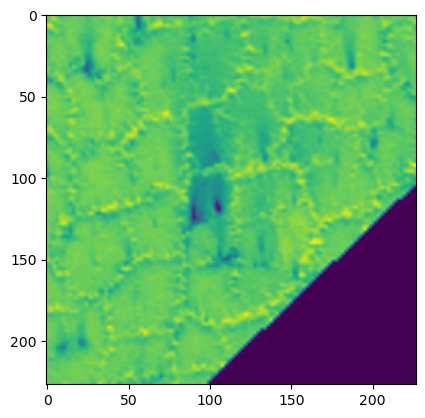

In [6]:
plt.imshow(labels_df['pixels'][0])

<Axes: xlabel='class', ylabel='count'>

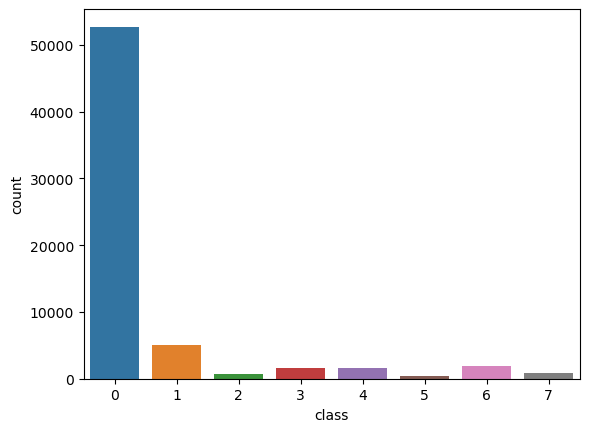

In [7]:
sns.countplot(x=labels_df['class'])

Most of the images are in the "other" category and the "crater" category.

In [8]:
labels_df['class'].value_counts()

0    52722
1     5024
6     1834
4     1654
3     1575
7      896
2      766
5      476
Name: class, dtype: int64

In [9]:
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64947 entries, 0 to 64946
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    64947 non-null  object
 1   class   64947 non-null  int64 
 2   pixels  64947 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.5+ MB


In [10]:
labels_df['pixels']

0        [[198, 195, 192, 195, 202, 198, 184, 171, 166,...
1        [[191, 190, 187, 185, 186, 186, 184, 184, 184,...
2        [[223, 222, 218, 220, 226, 223, 213, 208, 202,...
3        [[192, 190, 190, 189, 187, 185, 184, 185, 189,...
4        [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
                               ...                        
64942    [[161, 144, 107, 83, 89, 102, 110, 119, 133, 1...
64943    [[120, 108, 87, 91, 103, 131, 141, 137, 113, 1...
64944    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
64945    [[148, 143, 132, 116, 99, 90, 100, 117, 130, 1...
64946    [[0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 1, 0,...
Name: pixels, Length: 64947, dtype: object

## Model building

In [11]:
X = np.array(labels_df['pixels'].values.tolist())
y = labels_df['class'].values.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_PROP, random_state=SEED)

In [21]:
model = keras.Sequential([
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(227,227,1)),
    layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
    layers.MaxPool2D(2,2),
    layers.Dropout(0.25),
    
    layers.Conv2D(64, kernel_size=(3,3), activation='relu', input_shape=(227,227,1)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPool2D(2,2),
    layers.Dropout(0.25),
    
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.25),
    
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    
    layers.Dense(len(class_map), activation='softmax'),
])

optimizer = keras.optimizers.Adam(epsilon=0.01)
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

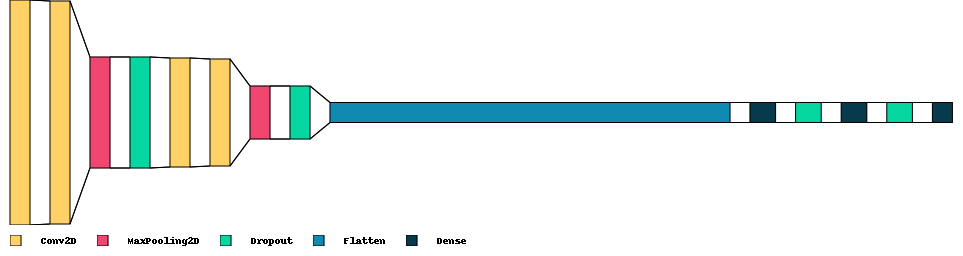

In [22]:
visualkeras.layered_view(model, scale_xy=1,legend=True, draw_volume=False, spacing=20)

In [23]:
X_train = list(X_train)
X_test = list(X_test)

list

In [16]:
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float16)
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float16)

In [24]:
history = model.fit(
    X_train_tensor, y_train,
    validation_data=(X_test_tensor, y_test),
    epochs=15
)

Epoch 1/15
  11/1624 [..............................] - ETA: 2:05:57 - loss: 75.7473 - accuracy: 0.6307

: 

: 

In [ ]:
labels_df['pixels'][0]

array([[198, 195, 192, ..., 169, 170, 171],
       [193, 192, 193, ..., 181, 178, 176],
       [179, 184, 193, ..., 199, 194, 190],
       ...,
       [190, 189, 185, ...,   0,   0,   0],
       [191, 189, 186, ...,   0,   0,   0],
       [191, 190, 186, ...,   0,   0,   0]], dtype=uint8)